C:\Users\pranu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\pranu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "



Check for null values:
node_features    0
edge_index       0
labels           0
dtype: int64

Cleaned data (after dropping nulls):
                                       node_features  \
0  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0....   
1  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0....   
2  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0....   
3  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0....   
4  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0....   

                                          edge_index labels  
0  [[0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 6,...    [1]  
1  [[0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6,...    [0]  
2  [[0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6,...    [0]  
3  [[0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 6,...    [1]  
4  [[0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5,...    [0]  
Cleaned dataset size: 188
Number of graphs: 188
Number of features per node: 7
Number of classes: 2


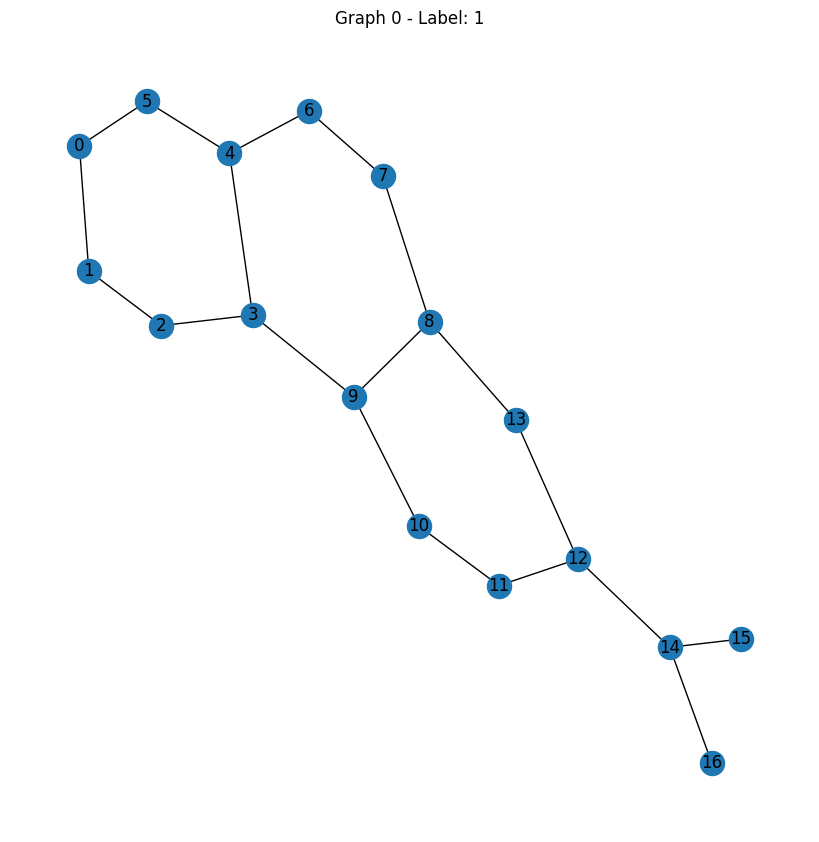

In [1]:
import torch
from torch_geometric.data import Data
import pandas as pd
from torch_geometric.datasets import TUDataset
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Load the MUTAG dataset (contains molecular graphs)
dataset = TUDataset(root="data", name="MUTAG")

# Convert dataset to a DataFrame for preprocessing
data_list = []
for i, graph in enumerate(dataset):
    
    node_features = graph.x.cpu().numpy()  # Convert node features to NumPy
    edge_index = graph.edge_index.cpu().numpy()  # Convert edge index to NumPy
    labels = graph.y.cpu().numpy()  # Get the label
    
    # Convert the graph data to a dict for DataFrame
    graph_data = {
        
        'node_features': node_features.tolist(),
        'edge_index': edge_index.tolist(),
        'labels': labels.tolist()
        
    }
    data_list.append(graph_data)

# Create a Pandas DataFrame
df = pd.DataFrame(data_list)

# Check for null values
print("\nCheck for null values:")
print(df.isnull().sum())

# Handle missing or irrelevant data
df_cleaned = df.dropna()  # Drop rows with null values, or you can use df.fillna() to fill them
print("\nCleaned data (after dropping nulls):")
print(df_cleaned.head())

# Now convert cleaned DataFrame back to graph format (PyTorch Geometric)
cleaned_graphs = []
for index, row in df_cleaned.iterrows():
    
    node_features = torch.tensor(row['node_features'], dtype=torch.float)
    edge_index = torch.tensor(row['edge_index'], dtype=torch.long)
    labels = torch.tensor(row['labels'], dtype=torch.long)

    cleaned_graph = Data(x=node_features, edge_index=edge_index, y=labels)
    cleaned_graphs.append(cleaned_graph)

# Print cleaned dataset details
print(f"Cleaned dataset size: {len(cleaned_graphs)}")
print(f"Number of graphs: {len(cleaned_graphs)}")
print(f"Number of features per node: {cleaned_graphs[0].num_features}")
print(f"Number of classes: {len(torch.unique(torch.tensor([g.y.item() for g in cleaned_graphs])))}")

# Convert first graph to NetworkX and visualize it
graph = cleaned_graphs[0]
nx_graph = to_networkx(graph, to_undirected=True)

plt.figure(figsize=(8, 8))
nx.draw(nx_graph, with_labels=True)
plt.title(f"Graph 0 - Label: {graph.y.item()}")
plt.show()


In [3]:
from torch_geometric.nn import DeepGCNLayer, GCNConv, global_mean_pool
import torch.nn as nn
import torch

class DeeperGCNGraphClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        
        super(DeeperGCNGraphClassifier, self).__init__()

        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))

        for _ in range(num_layers - 2):
            self.convs.append(DeepGCNLayer(GCNConv(hidden_channels, hidden_channels)))

        self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.pool = global_mean_pool  # Global pooling collapses node features into a single graph feature
        self.fc = nn.Linear(hidden_channels, out_channels)  # Fully connected layer for classification

    def forward(self, x, edge_index, batch):
        
        for conv in self.convs:
            x = conv(x, edge_index).relu()
        
        # Pooling: Aggregates node features into a graph representation
        x = self.pool(x, batch)
        
        return self.fc(x)


In [5]:
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures

# Split cleaned dataset
raw_train_dataset = cleaned_graphs[:150]
test_dataset = cleaned_graphs[150:]

# Define the manual edge drop function
def drop_edges(data, p=0.1):
    
    """Manually drops edges from the graph with probability p."""
    edge_index = data.edge_index
    num_edges = edge_index.size(1)

    # Randomly drop edges by sampling with probability p
    mask = torch.rand(num_edges) > p  # Create a mask with p probability
    edge_index = edge_index[:, mask]  # Keep only the edges that are not dropped

    # Return the modified graph data with dropped edges
    return data.__class__(x=data.x, edge_index=edge_index, y=data.y, batch=data.batch)

# Apply edge dropout and normalization
transform = NormalizeFeatures()  # Normalize node features
train_dataset = [drop_edges(transform(data), p=0.2) for data in raw_train_dataset]  # Apply dropout after normalization


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DeeperGCNGraphClassifier(
    in_channels=cleaned_graphs[0].num_features, 
    hidden_channels=128, 
    out_channels=len(torch.unique(torch.tensor([g.y.item() for g in cleaned_graphs]))),
    num_layers=6
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)

criterion = torch.nn.CrossEntropyLoss()

# Training loop
num_epochs = 10  # Reduce epochs from 50 to 20
best_accuracy = 0
patience = 5  # If no improvement for 5 epochs, stop early
patience_counter = 0

for epoch in range(num_epochs):
    
    model.train()  # Set the model to training mode
    total_loss = 0
    
    for data in train_loader:
        
        data = data.to(device)
        optimizer.zero_grad()  # Reset gradients
        out = model(data.x, data.edge_index, data.batch)  # Forward pass
        loss = criterion(out, data.y)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        total_loss += loss.item()  # Accumulate loss for the epoch

    # Evaluate on validation or test data after each epoch for early stopping
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        
        for data in test_loader:
            
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)  # Get the predicted class
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)

    accuracy = correct / total * 100  # Calculate accuracy

    print(f"Epoch {epoch}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Early stopping condition
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        patience_counter = 0
    else:
        patience_counter += 1

    # Stop training if no improvement for 'patience' epochs
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break



Epoch 0, Loss: 3.3018, Accuracy: 68.42%
Epoch 1, Loss: 3.1472, Accuracy: 68.42%
Epoch 2, Loss: 3.1788, Accuracy: 68.42%
Epoch 3, Loss: 3.1089, Accuracy: 68.42%
Epoch 4, Loss: 3.0570, Accuracy: 68.42%
Epoch 5, Loss: 3.0591, Accuracy: 68.42%
Early stopping triggered.


In [4]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    
    for data in test_loader:
        
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")


NameError: name 'model' is not defined

In [ ]:
torch.save(model.state_dict(), "deepergcn_mutag.pth")


In [ ]:
model.load_state_dict(torch.load("deepergcn_mutag.pth"))
model.eval()
